# Proyek Klasifikasi Gambar: [DIGITS]
- **Nama:** [Dwi Tatang Warianta]
- **Email:** [tatangwarianta@students.unnes.ac.id]
- **ID Dicoding:** [dwi_tatang_warianta]

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import files
import os, shutil, zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np

In [3]:
!pip install -q kaggle tensorflowjs

## Data Preparation

### Data Loading

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

In [6]:
!kaggle datasets download -d karnikakapoor/digits -p /content --force

Dataset URL: https://www.kaggle.com/datasets/karnikakapoor/digits
License(s): CC0-1.0
  0% 0.00/33.2M [00:00<?, ?B/s]
100% 33.2M/33.2M [00:00<00:00, 698MB/s]


In [7]:
with zipfile.ZipFile("/content/digits.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [8]:
base_dir = "/content/digits updated/digits updated"

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(folder_path, fname))
                labels.append(label)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

### Data Preprocessing

#### Split Dataset

In [9]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [10]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(train_df, x_col='filepath', y_col='label',
                                        target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
val_gen = datagen.flow_from_dataframe(val_df, x_col='filepath', y_col='label',
                                      target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
test_gen = datagen.flow_from_dataframe(test_df, x_col='filepath', y_col='label',
                                       target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

Found 7112 validated image filenames belonging to 10 classes.
Found 1524 validated image filenames belonging to 10 classes.
Found 1524 validated image filenames belonging to 10 classes.


## Modelling

In [11]:
num_classes = len(train_gen.class_indices)

model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True)
]

## Evaluasi dan Visualisasi

In [14]:
history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.6571 - loss: 1.1855 - val_accuracy: 0.9698 - val_loss: 0.0935
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9714 - loss: 0.0916 - val_accuracy: 0.9856 - val_loss: 0.0403
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9829 - loss: 0.0544 - val_accuracy: 0.9941 - val_loss: 0.0258
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9890 - loss: 0.0348 - val_accuracy: 0.9928 - val_loss: 0.0246
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9904 - loss: 0.0301 - val_accuracy: 0.9941 - val_loss: 0.0240
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9904 - loss: 0.0287 - val_accuracy: 0.9915 - val_loss: 0.0247
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9933 - loss: 0.0177 - val_accuracy: 0.9921 - val_loss: 0.0244
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9913 - loss: 0.0247 - val_accuracy: 0.99

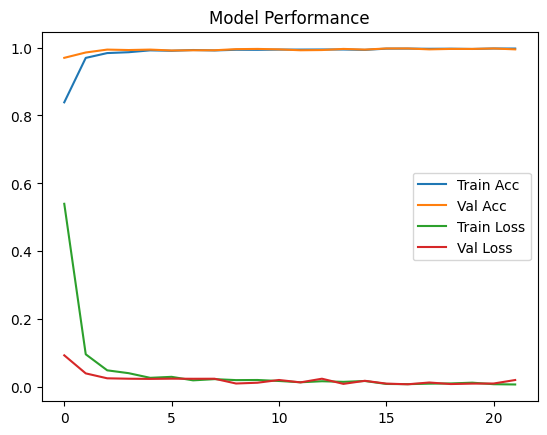

In [15]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Performance")
plt.legend()
plt.show()

In [16]:
train_loss, train_acc = model.evaluate(train_gen)
print(f"\n✅ Akurasi Training Set: {train_acc * 100:.2f}%")

test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Akurasi Testing Set: {test_acc * 100:.2f}%")

223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 1.0000 - loss: 5.1469e-05

✅ Akurasi Training Set: 100.00%
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9983 - loss: 0.0103
✅ Akurasi Testing Set: 99.67%


## Konversi Model

In [19]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137778873673360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778873674128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778873673744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778873677008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778873676240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778873677968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778873677776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137778873678544: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

In [21]:
labels = list(train_gen.class_indices.keys())
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

In [22]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-30 09:33:08.858772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746005588.878457    4089 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746005588.884368    4089 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-30 09:33:14.068854: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746005594.069018    4089 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

In [32]:
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
required_shape = input_details[0]['shape']
target_height, target_width = required_shape[1], required_shape[2]

In [33]:
sample = test_df.iloc[0]
img = Image.open(sample['filepath']).convert("RGB").resize((target_width, target_height))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

In [34]:
output = interpreter.get_tensor(output_details[0]['index'])[0]
predicted_index = np.argmax(output)

In [35]:
with open("tflite/label.txt", "r") as f:
    labels = f.read().splitlines()

print("📷 Gambar:", sample['filepath'])
print("✅ Label Asli:", sample['label'])
print("🔮 Prediksi:", labels[predicted_index])

📷 Gambar: /content/digits updated/digits updated/8/img009-00650.png
✅ Label Asli: 8
🔮 Prediksi: 8
